本文件是基于回归树的的模型的训练与测试文件。<br>
在运行preprocess.ipynb文件后再运行此文件，可以完成Bagging GBRT的训练及测试。<br>
若修改此文件的相应参数，则可以训练并测试其它基于回归树的模型。<br>
代码中关键参数的含义都已有相应注释。

In [16]:
import pandas as pd
import numpy as np
import os 
import time

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier


from sklearn.metrics import confusion_matrix

from multiprocessing import Pool

import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import warnings 
warnings.filterwarnings("ignore")
import matplotlib
matplotlib.rcParams[u'font.sans-serif'] = ['SimHei'] 
matplotlib.rcParams['axes.unicode_minus'] = False

from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

from sklearn.externals import joblib 

In [2]:
# 改变此处time_in 即可改变输入时间长度
def data_generate(data_type_filled):
    time_in = 6
    time_out = 6

    num_sample = data_type_filled['PM2.5'].shape[0] -time_in -time_out
    num_loc = data_type_filled['PM2.5'].shape[1] -3
        
    num_feature = len(data_type_filled)
    data = []
    label = []
    data_filled_array = {}
    for type_now in data_type_filled:
        data_filled_array[type_now] = data_type_filled[type_now].iloc[:,3:].values
        
    start = time.time()
    for i in range(0,num_sample):
#         data_now = np.zeros([time_in, num_feature, num_loc])
        data_now = np.zeros([time_in, num_feature-1, num_loc]) #舍去PM2.5 or PCA
        feature_now = -1
        

        # 判断date是否连续
        if data_type_filled['PM2.5'].iloc[i+time_in+time_out-1,0] - data_type_filled['PM2.5'].iloc[i,0] < 2:
            # 判断hour是否连续
            if data_type_filled['PM2.5'].iloc[i+time_in+time_out-1,1] == (data_type_filled['PM2.5'].iloc[i,1] + time_in+time_out-1)%24: 
                for type_now in data_type_filled:
#                     if type_now == 'PCA': #选择只要PCA特征
                    if type_now == 'PM2.5': #选择只要PM2.5特征
                        feature_now = feature_now +1
                        data_now[:,feature_now,:] = data_filled_array[type_now][i:i+time_in,:].copy()
                    if type_now == 'PM2.5':
                        label_now = data_filled_array[type_now][i+time_in:i+time_in+time_out,:].copy()
                        
#                 data_now = data_now.reshape((time_in*num_feature,num_loc))
                data_now = data_now.reshape((time_in*(num_feature-1),num_loc)) #舍去PM2.5 or PCA
                data.append(data_now)
                label.append(label_now)
        
    end = time.time()
#     print('data generating lasted: '+str(end-start))
           
    data = np.array(data)
    label = np.array(label)
    if label[label==0].shape[0]>0:
        print('there is a bug')
    return data, label

In [3]:
def data_split(loc):
    print(loc)
    # 读取数据
#     data_all = pd.read_csv('../data_mix_clean/'+loc+'.csv')
    data_all = pd.read_csv('../data_mix_clean_pca/'+loc+'.csv')
    data_all = data_all.iloc[:,1:]
    # 划分数据集
    data_train = data_all[data_all['date'] < 20200000]
    data_train = data_train[data_train['date'] > 20150000]
    data_val = data_all[data_all['date'] > 20200000]
    data_test = data_all[data_all['date'] < 20150000]
    # 制作时序数据集
    list_type = np.unique(data_all['type']).tolist()
    data_train_type = {}
    data_val_type = {}
    data_test_type = {}
    for data_type in list_type:
        data_train_type[data_type] = data_train[data_train['type']==data_type]
        data_val_type[data_type] = data_val[data_val['type']==data_type]
        data_test_type[data_type] = data_test[data_test['type']==data_type]

    train_data,train_label = data_generate(data_train_type)
    val_data,val_label = data_generate(data_val_type)
    test_data,test_label = data_generate(data_test_type)
    
    return [train_data,train_label,val_data,val_label,test_data,test_label,loc]

In [4]:
# 并行程序，进行数据集划分
list_loc = np.load("../location.npy",allow_pickle=True)
MultiNum = 17
pool = Pool(processes=MultiNum)
dataset_splited_list = pool.map(data_split,list_loc)
pool.close()
pool.join()

东四
天坛
官园
万寿西宫
北部新区
万柳
奥体中心
房山
农展馆
云岗
大兴
丰台花园
顺义
通州
亦庄
古城
昌平
门头沟
怀柔
平谷
延庆
密云
八达岭
定陵
密云水库
东高村
永乐店
榆垡
琉璃河
前门
永定门内
西直门北
南三环
东四环


In [5]:
# 检查数据格式
print(dataset_splited_list[0][0].shape)
print(dataset_splited_list[0][1].shape)

(34695, 6, 1)
(34695, 6, 1)


In [17]:
def para_pass(args):
    return train_pre(*args)

def train_pre(train_data,train_label,val_data,val_label,test_data,test_label,loc, model_name):
    # 训练模型
    print(model_name+' '+loc)
    train_predict = np.zeros(train_label.shape)
    val_predict = np.zeros(val_label.shape)
    test_predict = np.zeros(test_label.shape)

    for ti in range(train_label.shape[1]):
        if model_name =='RT':
            model = DecisionTreeRegressor(max_depth = 3)
        elif model_name =='RF':
            model = RandomForestRegressor(n_estimators=10 ,max_depth = 10, max_features=1.0, max_samples=None)
        elif model_name =='BaggingGBRT':
            model = BaggingRegressor(base_estimator = GradientBoostingRegressor(n_estimators=80,max_depth = 5),n_estimators=20,max_samples=0.7,max_features=1.0)
        elif model_name =='Ada_RT':
            model = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=5),n_estimators=10)
#             model = AdaBoostRegressor(base_estimator = GradientBoostingRegressor(n_estimators=80,max_depth = 10),n_estimators=10)
        elif model_name =='GBRT':
            model = GradientBoostingRegressor(n_estimators=80,max_depth = 10)

        lo = 0
        model.fit(train_data[:,:,lo], train_label[:,ti,lo])
        train_predict[:,ti,lo] = model.predict(train_data[:,:,lo])
        val_predict[:,ti,lo] = model.predict(val_data[:,:,lo])
        test_predict[:,ti,lo] = model.predict(test_data[:,:,lo])
        
        joblib.dump(model, './BestModels/'+model_name+'_'+loc+'.pkl')  #保存模型
            
    return [train_predict,val_predict,test_predict,loc]

In [18]:
# 修改此处models，即可选择不同模型
# 'BaggingGBRT'在16核CPU上训练需要500秒
models = ['BaggingGBRT']
result_models = {}

# 并行程序，训练模型
MultiNum = 17
pool = Pool(processes=MultiNum)

for model_name in models:
    start = time.time()
    para_list = []
    for train_data,train_label,val_data,val_label,test_data,test_label,loc in dataset_splited_list:
        para_list.append([train_data,train_label,val_data,val_label,test_data,test_label,loc,model_name])
    result_pre_list = pool.map(para_pass,para_list)
    result_models[model_name] = result_pre_list

    end = time.time()
    print('training lasted: '+str(end-start))
pool.close() 
pool.join()

BaggingGBRT 东四
BaggingGBRT 天坛
BaggingGBRT 官园
BaggingGBRT 万寿西宫
BaggingGBRT 奥体中心
BaggingGBRT 农展馆
BaggingGBRT 万柳
BaggingGBRT 北部新区
BaggingGBRT 丰台花园
BaggingGBRT 云岗
BaggingGBRT 古城
BaggingGBRT 房山
BaggingGBRT 大兴
BaggingGBRT 亦庄
BaggingGBRT 通州
BaggingGBRT 顺义
BaggingGBRT 昌平
BaggingGBRT 门头沟
BaggingGBRT 平谷
BaggingGBRT 怀柔
BaggingGBRT 密云
BaggingGBRT 延庆
BaggingGBRT 定陵
BaggingGBRT 八达岭
BaggingGBRT 密云水库
BaggingGBRT 东高村
BaggingGBRT 永乐店
BaggingGBRT 榆垡
BaggingGBRT 琉璃河
BaggingGBRT 前门
BaggingGBRT 永定门内
BaggingGBRT 西直门北
BaggingGBRT 南三环
BaggingGBRT 东四环
training lasted: 503.7681415081024


In [10]:
# 定义评价指标
def Evaluation(label, predict):
    MAE = np.mean(np.abs(label - predict))
    RMSE = np.power(np.mean(np.power(label - predict,2)) ,0.5)

    label_grade = label.copy()
    label_grade[label_grade <= 35] = 1
    label_grade[label_grade > 250] = 6
    label_grade[label_grade > 150] = 5
    label_grade[label_grade > 115] = 4
    label_grade[label_grade > 75] = 3
    label_grade[label_grade > 35] = 2
    
    predict_grade = predict.copy()
    predict_grade[predict_grade <= 35] = 1
    predict_grade[predict_grade > 250] = 6
    predict_grade[predict_grade > 150] = 5
    predict_grade[predict_grade > 115] = 4
    predict_grade[predict_grade > 75] = 3
    predict_grade[predict_grade > 35] = 2
    
    Accu = accuracy_score(label_grade,predict_grade)
    return MAE,RMSE,Accu

def Evaluation_PR(label, predict):

    label_grade = label.copy()
    label_grade[label_grade <= 35] = 1
    label_grade[label_grade > 250] = 6
    label_grade[label_grade > 150] = 5
    label_grade[label_grade > 115] = 4
    label_grade[label_grade > 75] = 3
    label_grade[label_grade > 35] = 2
    
    predict_grade = predict.copy()
    predict_grade[predict_grade <= 35] = 1
    predict_grade[predict_grade > 250] = 6
    predict_grade[predict_grade > 150] = 5
    predict_grade[predict_grade > 115] = 4
    predict_grade[predict_grade > 75] = 3
    predict_grade[predict_grade > 35] = 2
    
    Prec = precision_score(label_grade, predict_grade, average=None)
    Rec = recall_score(label_grade, predict_grade, average=None)
    return Prec,Rec

In [11]:
# 计算评价指标
for model_name in models:
    MAE = np.zeros([3,len(result_models[model_name]),6])
    RMSE = np.zeros([3,len(result_models[model_name]),6])
    PREC = np.zeros([3,len(result_models[model_name]),6])
    
    Precision = np.zeros([3,len(result_models[model_name]),6,6])
    Recall = np.zeros([3,len(result_models[model_name]),6,6])
    
    count_correct = 0
    count_all = 0
    count_correct_1 = 0
    count_all_1 = 0
    for ti in range(6):
        for train_predict,val_predict,test_predict,loc_pre in result_models[model_name]:
            idx_loc = list_loc.tolist().index(loc_pre)
            for _,train_label,_,val_label,_,test_label,loc_label in dataset_splited_list:
                if loc_pre == loc_label:
                    MAE[0,idx_loc,ti], RMSE[0,idx_loc,ti],PREC[0,idx_loc,ti]= Evaluation(train_label[:,ti,:],train_predict[:,ti,:])
                    MAE[1,idx_loc,ti], RMSE[1,idx_loc,ti],PREC[1,idx_loc,ti]= Evaluation(val_label[:,ti,:],val_predict[:,ti,:])
                    MAE[2,idx_loc,ti], RMSE[2,idx_loc,ti],PREC[2,idx_loc,ti]= Evaluation(test_label[:,ti,:],test_predict[:,ti,:])

                    Precision[0,idx_loc,ti,:],Recall[0,idx_loc,ti,:] = Evaluation_PR(train_label[:,ti,:],train_predict[:,ti,:])
#                     Precision[1,idx_loc,ti,:],Recall[1,idx_loc,ti,:] = Evaluation_PR(val_label[:,ti,:],val_predict[:,ti,:])
                    Precision[2,idx_loc,ti,:],Recall[2,idx_loc,ti,:] = Evaluation_PR(test_label[:,ti,:],test_predict[:,ti,:])

                    if ti == 0:
                        count_all_1 = count_all_1 + val_label[:,ti,:].shape[0]
                        count_correct_1 = count_correct_1 + PREC[1,idx_loc,ti]*val_label[:,ti,:].shape[0]

                    count_all = count_all + val_label[:,ti,:].shape[0]
                    count_correct = count_correct + PREC[1,idx_loc,ti]*val_label[:,ti,:].shape[0]
                    
#     np.save('../results/4_final_accuracy_'+model_name+'.npy',PREC)
#     np.save('../results/4_final_precision_'+model_name+'.npy',Precision)
#     np.save('../results/4_final_recall_'+model_name+'.npy',Recall)
                    
print('one later hour: ' + str(count_correct_1 / count_all_1))                   
print('all later hour: ' + str(count_correct / count_all))

one later hour: 0.8793587746055432
all later hour: 0.7479554814310898


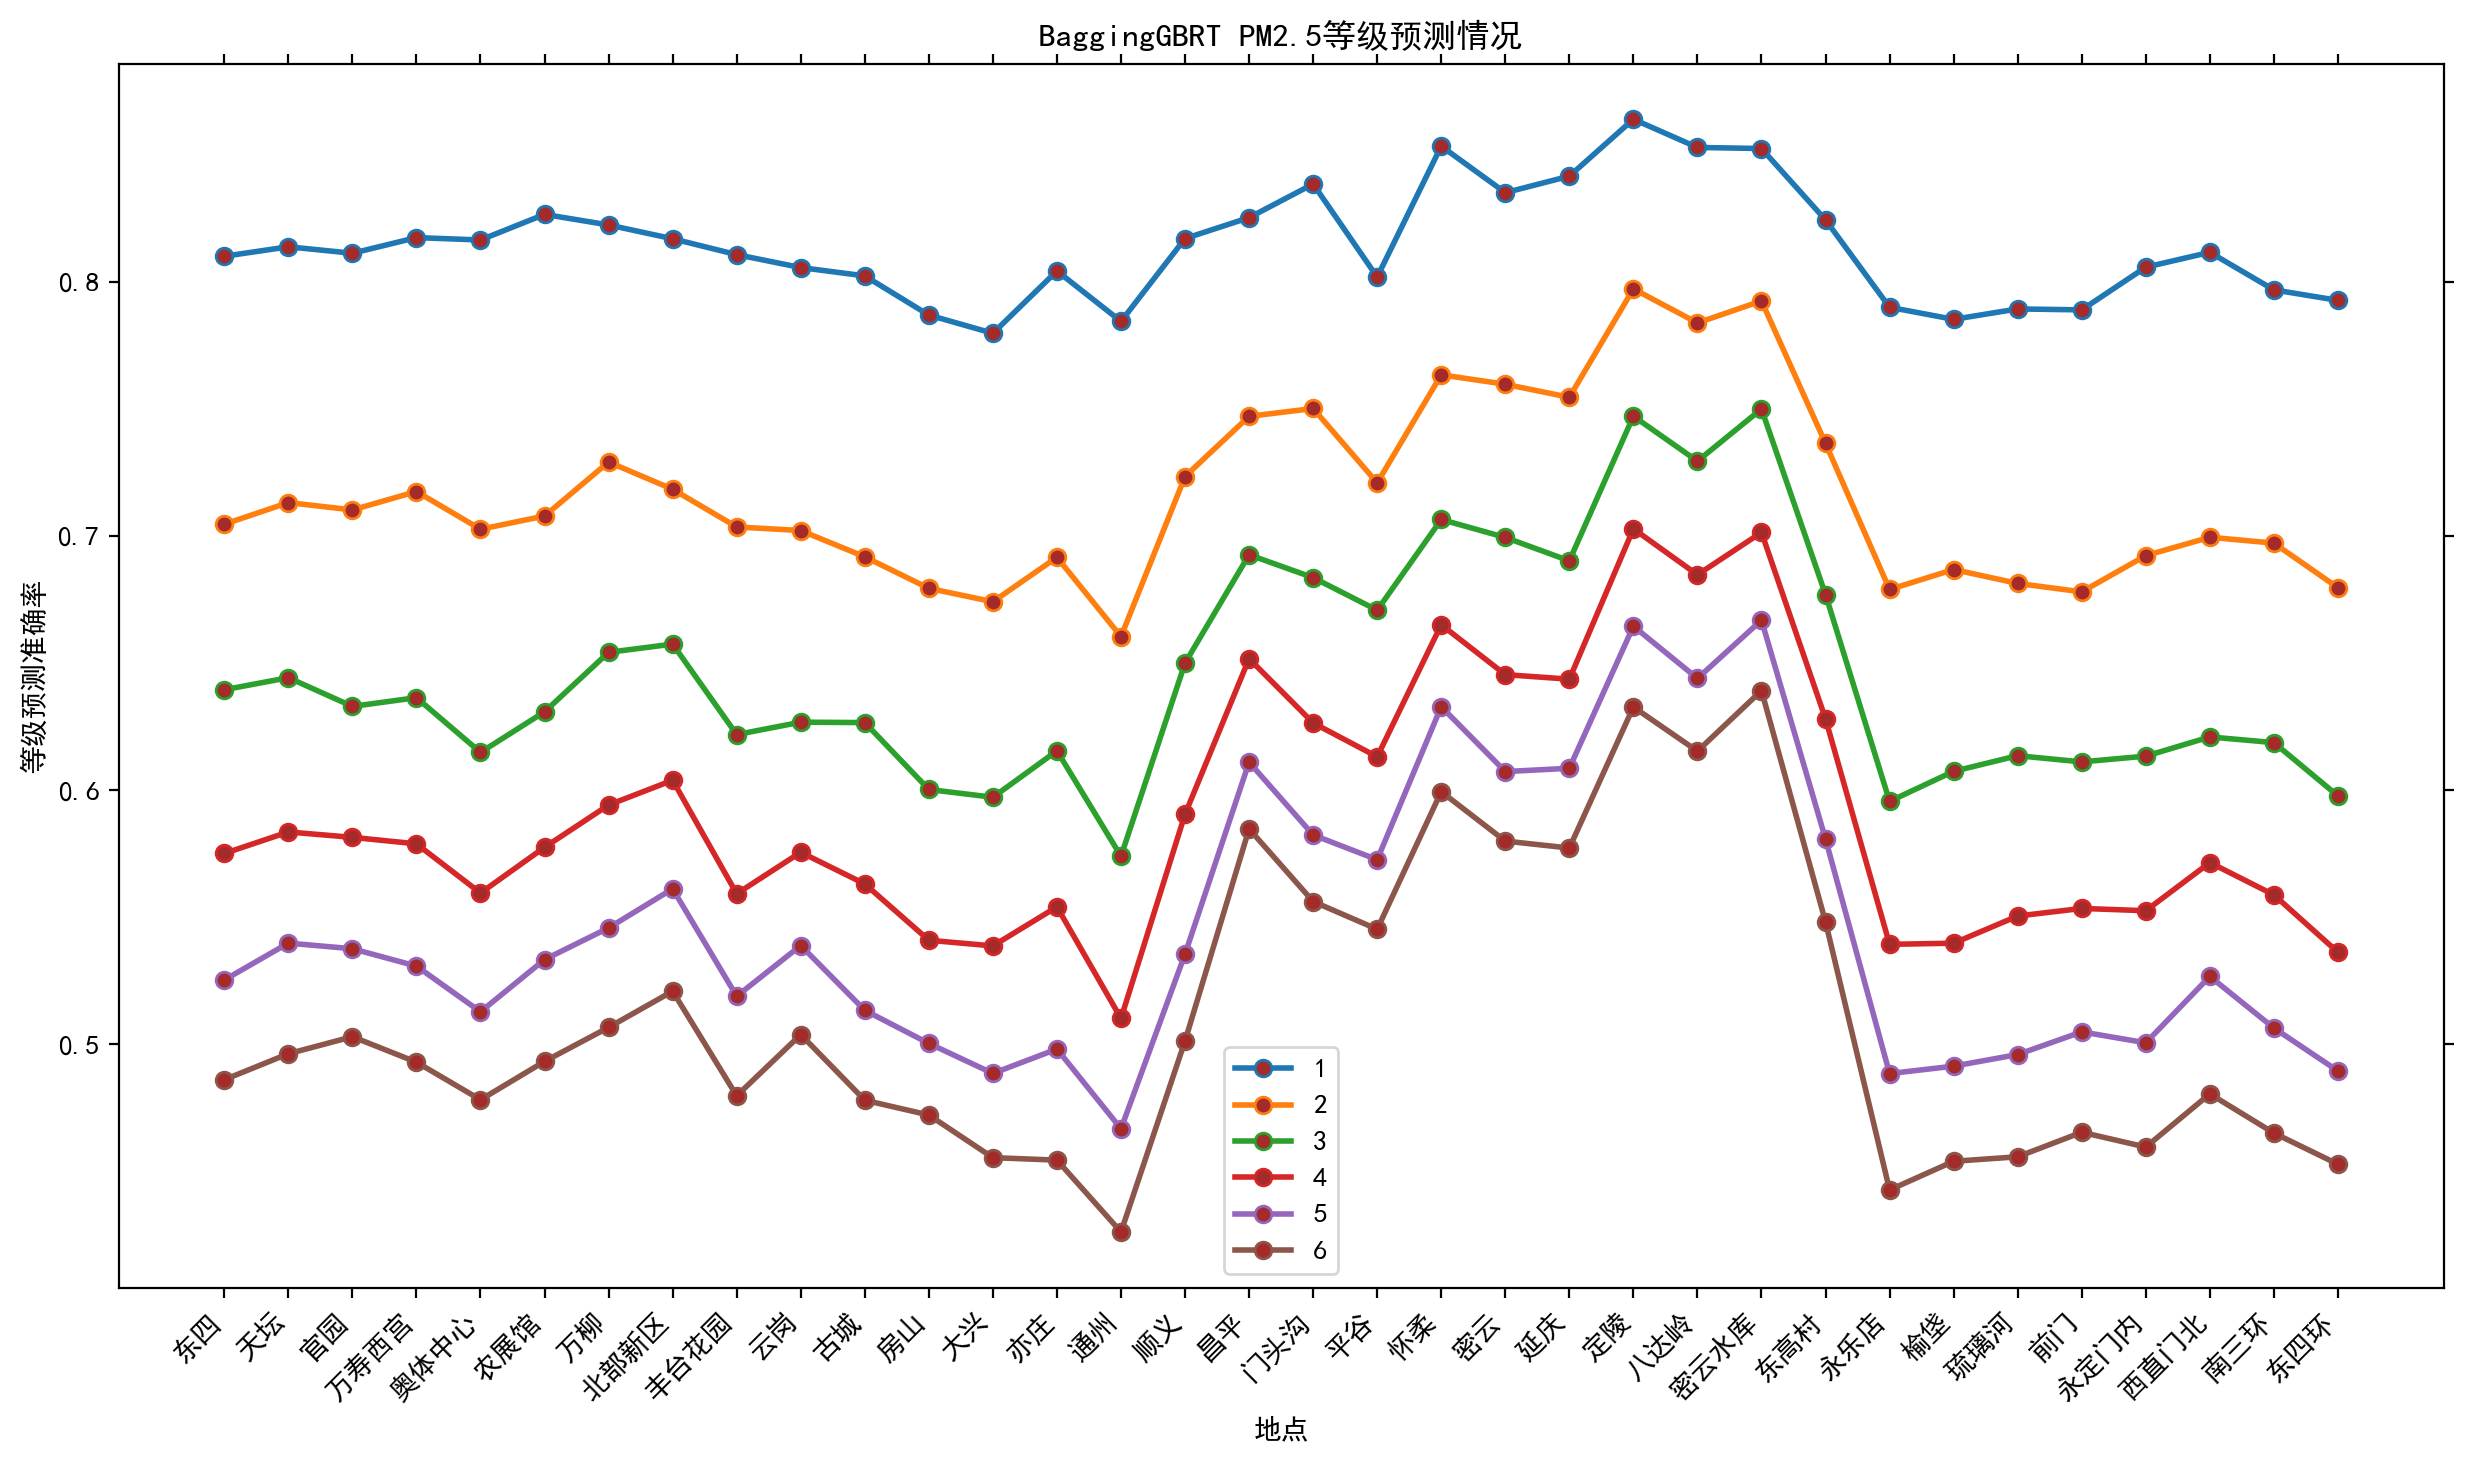

In [13]:
# 画图
fig = plt.figure(figsize = (15,9))
plt.rcParams['figure.dpi'] = 200 #分辨率
plt.plot(list_loc, # x轴数据
         PREC[2,:,:], # y轴数据
         linestyle = '-', # 折线类型
         linewidth = 2, # 折线宽度
#          color = 'steelblue', # 折线颜色
         marker = 'o', # 点的形状
         markersize = 6, # 点的大小
#          markeredgecolor='black', # 点的边框色
         markerfacecolor='brown') # 点的填充色
plt.title('BaggingGBRT PM2.5等级预测情况')
plt.xlabel('地点')
plt.ylabel('等级预测准确率')
plt.tick_params(top = 'off', right = 'off')
fig.autofmt_xdate(rotation = 45)
# 设置图例
plt.legend([1,2,3,4,5,6])
# plt.legend([1,2,3,4,5,6],bbox_to_anchor=(1.01,0.8))
# 显示图形
plt.show()